In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib import patches
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import pandas as pd

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots

In [3]:
opsim = 'baseline2018a'

In [4]:
opsdb = db.OpsimDatabase('db/baseline2018a.db')

In [5]:
opsdb.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

In [23]:
cols = ['observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fieldId', 'night', 'moonPhase']
sqlconstraint = 'proposalId = 3'
simdata = opsdb.fetchMetricData(cols, sqlconstraint)

In [28]:
se = stackers.SeasonStacker()
simdata = se.run(simdata)

In [29]:
simdata = pd.DataFrame(simdata)

In [141]:
simdata.query('fieldId > 310 and fieldId < 320').groupby(['fieldId', 'season'])['fieldId', 'season'].count()

fieldId  season
fieldId season                 
311     0.0          20      20
        1.0          77      77
        2.0         107     107
        3.0          93      93
        4.0          95      95
        5.0          91      91
        6.0          78      78
        7.0          97      97
        8.0          80      80
        9.0          81      81
        10.0         77      77
312     1.0          38      38
        2.0          70      70
        3.0          88      88
        4.0          95      95
        5.0          86      86
        6.0          84      84
        7.0          88      88
        8.0          88      88
        9.0          84      84
        10.0         84      84
        11.0         46      46
313     0.0           5       5
        1.0          85      85
        2.0         111     111
        3.0          96      96
        4.0         113     113
        5.0          90      90
        6.0          84      84
        7.0         101     101
...                 ...     ...
316     2.0          83      83
        3.0          90      90
        4.0          82      82
        5.0          84      84
        6.0          90      90
        7.0          83      83
        8.0          91      91
        9.0          69      69
        10.0         94      94
318     1.0          97      97
        2.0          70      70
        3.0         102     102
        4.0          87      87
        5.0          85      85
        6.0          93      93
        7.0          90      90
        8.0         100     100
        9.0          78      78
        10.0         96      96
319     0.0           2       2
        1.0         117     117
        2.0         100     100
        3.0         118     118
        4.0         105     105
        5.0          94      94
        6.0          74      74
        7.0         105     105
        8.0          80      80
        9.0          61      61
        10.0         90      90

[86 rows x 2 columns]

In [88]:
fields = [315, 2591, 1178]  # [-62 deg / circumpolar, -1, -35 .. and having about 80 observations in the season]

In [165]:
wfd_one = simdata.query('fieldId == 1178 and season==4')
moonmin = wfd_one.moonPhase.min()
newmoon = wfd_one.query('moonPhase == @moonmin').night.values[0]
newmoonmjd = wfd_one.query('moonPhase == @moonmin').observationStartMJD.values[0]
wfd_one.query('moonPhase < 0.2')

,observationStartMJD,filter,fieldRA,fieldDec,fieldId,night,moonPhase,year,season
648322,61029.110278,u,58.439764,-33.824727,1178,1177,0.176709,3.0,4.0


In [166]:
def calcxy(df):
    month = 30
    new = 1177
    newMJD = 61029.1102778
    x = (df.night - new) % month
    y = round((df.night - new) / month) 
    #y += df.offset * 4
    y += df.num/5
    return x, y

In [167]:
offset = []
num = []
for n in wfd_one.night.unique():
    match = wfd_one.query('night == @n')
    start = match.groupby('night')['observationStartMJD'].min().values[0]
    # Offset in time from start of observations in the night
    offset = np.concatenate([offset, match['observationStartMJD'].values - start])
    # Offset in number of observations from start of obs in night
    num = np.concatenate([num, np.arange(0, len(match), 1)])
wfd_one = wfd_one.assign(offset=offset)
wfd_one = wfd_one.assign(num=num)
x, y = calcxy(wfd_one)
y = y + 4
wfd_one = wfd_one.assign(x=x)
wfd_one = wfd_one.assign(y=y)
wfd_one.y.min()

0.0

In [168]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u': 'aqua', 'g': 'greenyellow', 'r': 'wheat', 'i': 'orange', 'z': 'r', 'y': 'm'}

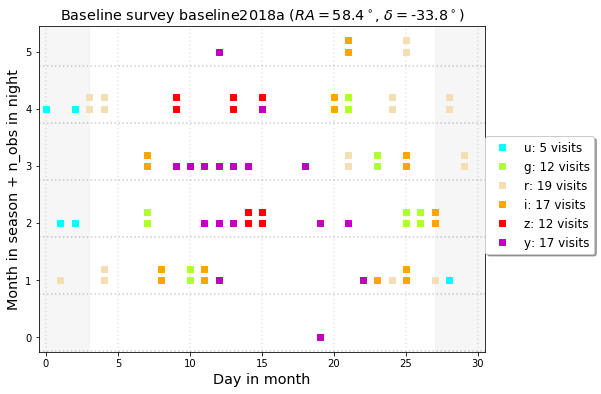

In [169]:
fieldid = wfd_one.fieldId.unique()[0]
ra = wfd_one.fieldRA.unique()[0]
dec = wfd_one.fieldDec.unique()[0]
fig = plt.figure(figsize=(8, 6))
for f in filterlist:
    match = wfd_one.query('filter == @f')
    nvis = len(match)
    plt.plot(match.x, match.y, color=filtercolors[f], linestyle='', marker='s', 
             label='%s: %d visits' % (f, nvis), zorder=10)
plt.legend(loc=(1, .3), fontsize='large', fancybox=True, shadow=True)
for i in range(0, 6, 1):
    plt.axhline(i - 0.25, color='k', linestyle=':', alpha=0.2)
for i in range(0, 35, 5):
    plt.axvline(i, color='k', linestyle=':', alpha=0.1)
plt.axvspan(-1, 3, alpha=0.2, color='lightgray', zorder=0)
plt.axvspan(27, 31, alpha=0.2, color='lightgray', zorder=0)
plt.xlim(-0.5, 30.5)
#plt.ylim(ymin=-0.3)
plt.title(r'Baseline survey baseline2018a ($RA=$%.1f$^\circ$, $\delta=$%.1f$^\circ$)' 
          % (ra, dec), fontsize='x-large')
plt.xlabel(r'Day in month', fontsize='x-large')
plt.ylabel(r'Month in season + n_obs in night', fontsize='x-large')
#newmoon = wfd_one.query('moonPhase < 10')
#x, y = calcxy(newmoon)
#y += 4
#plt.plot(x, y, linestyle='', color='k', marker='x', markersize=12, alpha=0.3)
plt.savefig('cadence_zenith.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

In [143]:
wfd_one = simdata.query('fieldId == 316 and season==4')
wfd_one.query('moonPhase < 1')

,observationStartMJD,filter,fieldRA,fieldDec,fieldId,night,moonPhase,year,season
618734,60970.361632,u,96.055377,-62.021153,316,1118,0.769294,3.0,4.0
635206,60999.287824,i,96.055377,-62.021153,316,1147,0.175049,3.0,4.0
635248,60999.309097,i,96.055377,-62.021153,316,1147,0.176098,3.0,4.0


In [144]:
def calcxy(df):
    month = 30
    new = 1147
    newMJD = 60999.287824
    x = (df.night - new) % month
    y = round((df.night - new) / month) 
    #y += df.offset * 4
    y += df.num/5
    return x, y

In [146]:
offset = []
num = []
for n in wfd_one.night.unique():
    match = wfd_one.query('night == @n')
    start = match.groupby('night')['observationStartMJD'].min().values[0]
    offset = np.concatenate([offset, match['observationStartMJD'].values - start])
    num = np.concatenate([num, np.arange(0, len(match), 1)])
wfd_one = wfd_one.assign(offset=offset)
wfd_one = wfd_one.assign(num=num)
x, y = calcxy(wfd_one)
y = y + 1
wfd_one = wfd_one.assign(x=x)
wfd_one = wfd_one.assign(y=y)
wfd_one.y.min()

0.0

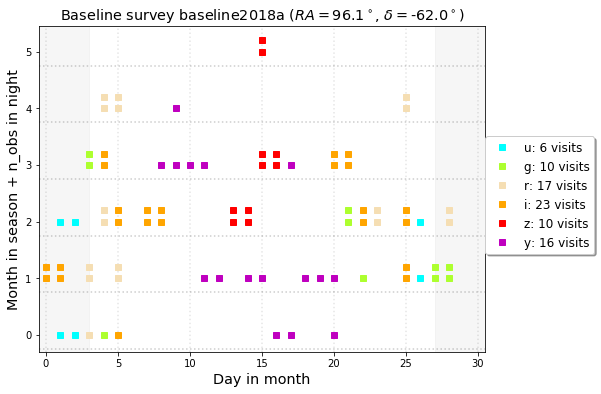

In [163]:
fieldid = wfd_one.fieldId.unique()[0]
ra = wfd_one.fieldRA.unique()[0]
dec = wfd_one.fieldDec.unique()[0]
fig = plt.figure(figsize=(8, 6))
for f in filterlist:
    match = wfd_one.query('filter == @f')
    nvis = len(match)
    plt.plot(match.x, match.y, color=filtercolors[f], linestyle='', marker='s', 
             label='%s: %d visits' % (f, nvis), zorder=10)
plt.legend(loc=(1, .3), fontsize='large', fancybox=True, shadow=True)
for i in range(0, 6, 1):
    plt.axhline(i - 0.25, color='k', linestyle=':', alpha=0.2)
for i in range(0, 35, 5):
    plt.axvline(i, color='k', linestyle=':', alpha=0.1)
plt.axvspan(-1, 3, alpha=0.2, color='lightgray', zorder=0)
plt.axvspan(27, 31, alpha=0.2, color='lightgray', zorder=0)
plt.xlim(-0.5, 30.5)
plt.ylim(ymin=-0.3)
plt.title(r'Baseline survey baseline2018a ($RA=$%.1f$^\circ$, $\delta=$%.1f$^\circ$)' 
          % (ra, dec), fontsize='x-large')
plt.xlabel(r'Day in month', fontsize='x-large')
plt.ylabel(r'Month in season + n_obs in night', fontsize='x-large')
#newmoon = wfd_one.query('moonPhase < 5')
#x, y = calcxy(newmoon)
#y += 1
#plt.plot(x, y, linestyle='', color='k', marker='x', markersize=12, alpha=0.3)
plt.savefig('cadence_circumpolar.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)